## Laboratory 4 - Characterizing the Angell Hall Telescope CCD

Elliott Pearson

All referenced files are included in the Bitbucket Repository 'Lab3'

### Abstract

In this laboratory, we conducted experiments to characterize the Angel Hall Observatory Telescope’s CCD. Our goal was to determine calibration values for the Gain, Read-Noise, Linearity, and Dark Current. To accomplish this, we collected a number of Bias, Flat, and Dark frame images that were evaluated by mean count level per pixel, standard deviation, and device temperature. We found the CCD to have a Gain of 2.438, a Read-Noise of 15.516, a Linearity range of 0.65 seconds, and a Dark Current-Temperature relationship with coefficients $A =$ 1.1e07 ADU/pixel/s and $E_g =$ 1.20 eV. These experiments helped to increase our understanding of the CCD instrumentation and will be used when we collect science-type frames with the Angel Hall Telescope for actual evaluation.

### Introduction

When it comes to data collection in the field of Astronomy, no instrumentation is more important than the Charge-Couple Device, or CCD. CCDs operate by capturing the energy carried by incoming photons, converting it to an electrical charge that is passed through the chip. Since astronomical data is most often collected from low light source objects – meaning low photon count and therefore low measurements read by the CCD – precision is important. The first step toward a high degree of precision is proper calibration.

In this lab, we plan to calibrate a CCD for gain, read-noise, linearity, and dark current using the Angel Hall Observatory’s telescope. This requires the collection of numerous Flat, Bias, and Dark-type images that can be evaluated by pixel intensity via the Python code demonstrated here. Detector temperature is also a critical variable for the measure of dark current in our CCD. With these four calibration values, we have everything we need to begin taking science images on the telescope and interpret the CCD signals appropriately.

### Theory

#### I. Gain
The first calibration for us to determine is gain. When a CCD is characterized by linear conversion between electrons and ADUs, gain can be measured by taking a number of different exposures at different light levels. This conversion factor is the gain, found by the comparison of the mean and standard deviation of both Flat and Bias frame images. Because of the lack of uniform light distribution in our sampling, we will have to constrain our images to a smaller size than measured by the CCD. We will collect two samples of each – that is, two Flat frames and two Bias frames – and solve for CCD gain using the equation:

\begin{align} 
Gain = \frac{(\bar{F}_1+\bar{F}_2)-(\bar{B}_1+\bar{B}_2)}{\sigma^{2}_{F_1-F_2}-\sigma^{2}_{B_1-B_2}}
\end{align}

#### II. Read-Noise
The next calibration is read-noise, defined as the standard deviation from the mean value at any given pixel location. Read-noise is generated by the CCD’s amplification process, necessary for the measure of electrons contained within the various detector pixels. A good-quality CCD will have a low read-noise. We measure read-noise through the analysis of zero second Bias Frames. Again, smaller scale samples extracted from the CCD image are needed to compensate for irregular light patterning and flaws in the chip. Given that no photons are hitting the CCD, a uniform field of zero intensity pixels is expected. This is not always the case, and we can measure the deviation against the mean via the equation described below:

\begin{align} 
Read Noise = \frac{Gain*\sigma_{B_1-B_2}}{\sqrt2}
\end{align}

#### III. Linearity
Linearity is another important property of a good CCD, as one would want a uniform linear response function over a wide range of electron counts to ensure reliability of their measurements. In order to calculate linearity of the Angel Hall CCD, we will collect Flat frame images at 10 different exposure times and compare them graphically for mean pixel count level. We would expect to observe a clear linear trend in the data until a certain point, the threshold of our CCD’s linear behavior, and a deviation in trend following that. This threshold value is an important constraint on actual data collection with this telescope.

#### IV. Dark Current
The last important calibration value for our CCD is the dark current, caused by electrons boosted into the conduction band by thermal excitation. Since the only cooling system available to our subject CCD is an internal fan, we can expect an observable amount of dark current in our measurements. Dark current varies according to the relationship:

\begin{align} 
Dark Current = AT^{3/2}exp(\frac{-E_g}{2kT})
\end{align}

Where $A$ is a constant in ADU/pixel/s, $E_g$ is the difference between the energy at the Fermi level and the bottom of the conduction band for the semiconductor, and $T$ is the detector temperature. It is the $A$ and $E_g$ values that we seek to determine experimentally. In order to accomplish this, we will take 10 Dark frames as the CCD warms up and plot the mean pixel count level as a function of temperature. Values for $A$ and $E_g$ can then be determined by a regression-based analysis, provided by the SciPy Curve_Fit( ) function. Given that the $E_g$ value (also known as the Band Gap Value) for silicon is around 1.11 eV at 302K, we can conclude that our $E_g$ will be something reasonably close.


### Methodology

#### I. Gain
We started by reading in the FITS data from the two Bias frames (BIAS1 and BIAS2) and the two Flat frames (FLAT1 and FLAT2). The images were evaluated for uniform regions that could be compared, and the matrices were restricted to include only this data. The graphs illustrate pixel count returned by the CCD, compensated with flatten() and binning commands.

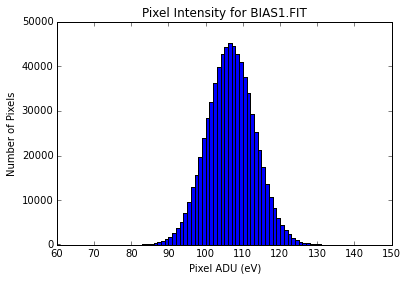

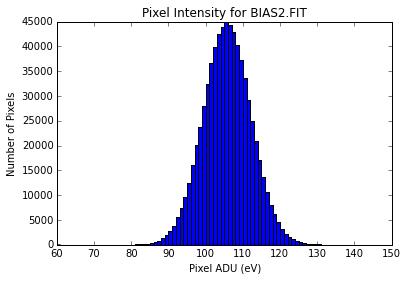

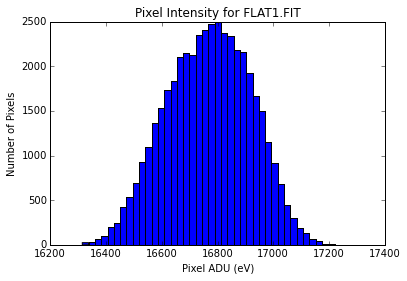

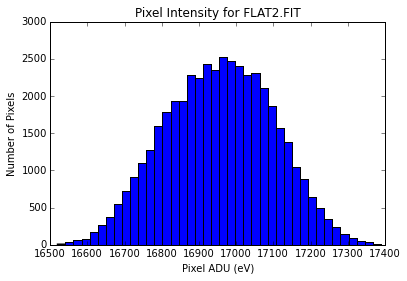

In [2]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from astroML.plotting import hist
from astropy.io import fits
from pylab import *
%matplotlib inline


#Variable Declerations
offset = 100
Fbin = 40
Bbin = 90


#Bias Images

#Read in BIAS1.FIT
B1data0 = fits.getdata("BIAS1.FIT")
#Restrict data to uniform field
B1data = B1data0[200:800, 200:1400]
#Plot data in a histograph
plt.hist(B1data.flatten(), bins=Bbin, range=[60, 150])
#Sets the plot title
plt.title('Pixel Intensity for BIAS1.FIT')
#Sets the plot axis
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
#Displays the plot
plt.show()

B2data0 = fits.getdata("BIAS2.FIT")
B2data = B2data0[200:800, 200:1400]
plt.hist(B2data.flatten(), bins=Bbin, range=[60, 150])
plt.title('Pixel Intensity for BIAS2.FIT')
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()


#Flat Images
F1data0 = fits.getdata("FLAT1.FIT")
F1data = F1data0[700:850, 650:950]
plt.hist(F1data.flatten(), bins=Fbin, range=[16315, 17219])
plt.title('Pixel Intensity for FLAT1.FIT')
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()

F2data0 = fits.getdata("FLAT2.FIT")
F2data = F2data0[700:850, 650:950]
plt.hist(F2data.flatten(), bins=Fbin, range=[16519, 17389])
plt.title('Pixel Intensity for FLAT2.FIT')
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()


The following function uses the Gain Formula seen in our theory to produce a numerical value for the CCD Gain when provided with the count arrays for two Flat and two Bias frames. 

In [46]:
# Gain Function
def Gain(F1, F2, B1, B2):
    F1m = np.mean(F1)
    F2m = np.mean(F2)
    B1m = np.mean(B1)
    B2m = np.mean(B2)
    
    # Gain formula, see 'Theory'
    Gain = ((F1m+F2m)-(B1m+B2m))/((np.std(F1-F2)**2)-(np.std(B1-B2)**2))
    
    return Gain

Next, we call the Gain() Function for the FIT files read into the program previous. This returns a value for Gain - the first of our required calibration factors.

In [48]:
# Gain 
# Calculated from BIAS1.FIT, BIAS2.FIT, FLAT1.FIT, FLAT2.FIT

Gain(F1data, F2data, B1data, B2data)

2.4383946787451536

Based on these results, the Gain Factor for the Angel Hall Telescope's CCD is around 2.438

#### II. Read-Noise

Next, we want to calibrate for the Read-Noise produced in the CCD due to amplification. This is determined by the below ReadNoise() function, which takes as input two Flat and two Bias frame count arrays, calling on the Gain() function to calculate the Read-Noise from the equation provided in our theory.

In [191]:
# Read-Noise Function
def ReadNoise(F1, F2, B1, B2):
    G = Gain(F1, F2, B1, B2)
    
    # Read-Noise formula, see 'Theory'
    ReadNoise = (G*(np.std(B1-B2)))/np.sqrt(2)
    
    return ReadNoise

We call the ReadNoise() Function for our four FIT files using the command:

In [192]:
# Read-Noise 
# Calculated from BIAS1.FIT, BIAS2.FIT, FLAT1.FIT, FLAT2.FIT

print ReadNoise(F1data,F2data,B1data,B2data)

15.5156864184


The calibration factor for Read-Noise on the CCD is found to be 15.516

#### III. Linearity

Next is our calculation of the CCD's linearity. Since this requires ten seperate data sets, we begin by declaring some variable arrays and constants to keep track of the values. Each frame potentially has a unique offset and plot binning, so these values were stored in array format.

In [49]:
#Declarations
offset  = [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]
binless = [ 70,  70,  70,  70,  70,  70,  70,  70,  70,  70]

MCount  = [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]
exposure= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,   1]

maxim = 0
minim = 0

First, we read in the data from our 0-second Bias frames; BIAS_A.FIT, BIAS_B.FIT, and BIAS_C.FIT. These count arrays were restricted down to smaller, more uniform regions on the CCD and a Mean Bias Compensation value was produced. This number represents the charge count observed by the CCD when no data is actually taken, so it must be subtracted off our actual data sets later to produce 'true', or unbiased measurements.

In [51]:
#Bias Compensation
BAdata0 = fits.getdata("BIAS_A.FIT")
BAdata = BAdata0[150:300, 200:400]

BBdata0 = fits.getdata("BIAS_B.FIT")
BBdata = BBdata0[150:300, 200:400]

BCdata0 = fits.getdata("BIAS_C.FIT")
BCdata = BCdata0[150:300, 200:400]

offmean = (np.mean(BAdata) + np.mean(BBdata) + np.mean(BCdata))/3
print offmean

86.9878234863


We took ten Flat-field frames, at exposure times ranging from 100 ms to 1000 ms (0.1 to 1 seconds). Like the Bias Frames, the count arrays measured by the CCD were restricted to uniform regions based on a visual comparison. From these regions, a mean pixel count level was calculated and limits were determined via a range of 3 standard deviations of the mean to eliminate and distant outliers or bad pixels. The count level was plotted against number of pixels, the data flattened and the Bias Compensation accounted for. 

100ms Exposure
Min: 12390.1552277 Max: 13509.3896942


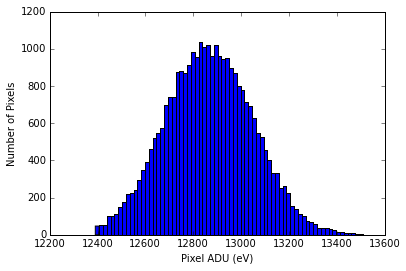

In [52]:
#100ms Exposure

#Read in data from FLAT100ms.FIT
F100data0 = fits.getdata("FLAT100ms.FIT")
#Restrict count array to uniform region
F100data = F100data0[150:300, 200:400]
#Calculate minimum and maximum expression value limits based on 3 standard deviations
minim = np.mean(F100data)-(np.std(F100data))*3
maxim = np.mean(F100data)+(np.std(F100data))*3
#Plot a histograph of the pixel counts within this range
hist(F100data.flatten()+offset[0]-offmean, bins=binless[0], range=[minim, maxim])
#Label Exposure tiem, minimum count limit, maximum count limit
print "100ms Exposure"
print "Min:", minim, "Max:", maxim
#Label Graph
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
#Display Graph
plt.show()

All of our results follow this same, Gaussian-like distribution when plotting count level and number of pixels. The difference is seen in the mean value (the middle of the Gaussian curve) which increases steadily as exposure time is increased. This upward trend is what we are interested in.

200ms Exposure
Min: 16885.9205933 Max: 18220.7356567


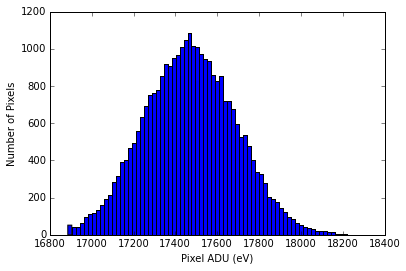

In [53]:
#200ms Exposure
F200data0 = fits.getdata("FLAT200ms.FIT")
F200data = F200data0[150:300, 200:400]
minim = np.mean(F200data)-(np.std(F200data))*3
maxim = np.mean(F200data)+(np.std(F200data))*3
hist(F200data.flatten()+offset[0]-offmean, bins=binless[0], range=[minim, maxim])
print "200ms Exposure"
print "Min:", minim, "Max:", maxim
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()

300ms Exposure
Min: 19532.2524261 Max: 20985.6069489


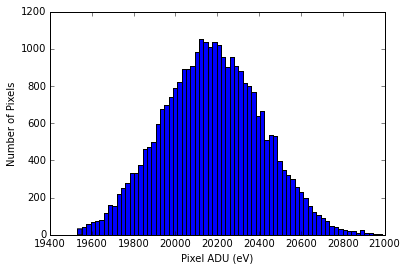

In [54]:
#300ms Exposure
F300data0 = fits.getdata("FLAT300ms.FIT")
F300data = F300data0[150:300, 200:400]
minim = np.mean(F300data)-(np.std(F300data))*3
maxim = np.mean(F300data)+(np.std(F300data))*3
hist(F300data.flatten()+offset[0]-offmean, bins=binless[0], range=[minim, maxim])
print "300ms Exposure"
print "Min:", minim, "Max:", maxim
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()

400ms Exposure
Min: 25524.4681091 Max: 27238.2545471


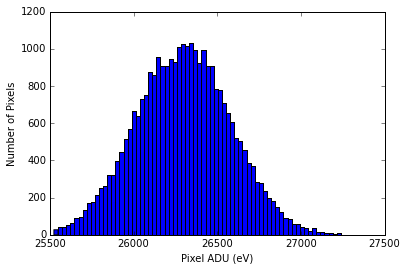

In [55]:
#400ms Exposure
F400data0 = fits.getdata("FLAT400ms.FIT")
F400data = F400data0[150:300, 200:400]
minim = np.mean(F400data)-(np.std(F400data))*3
maxim = np.mean(F400data)+(np.std(F400data))*3
hist(F400data.flatten()+offset[0]-offmean, bins=binless[0], range=[minim, maxim])
print "400ms Exposure"
print "Min:", minim, "Max:", maxim
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()

500ms Exposure
Min: 28179.1090698 Max: 30009.3401489


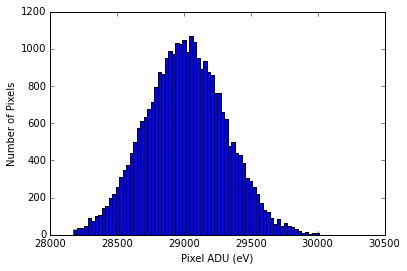

In [56]:
#500ms Exposure
F500data0 = fits.getdata("FLAT500ms.FIT")
F500data = F500data0[150:300, 200:400]
minim = np.mean(F500data)-(np.std(F500data))*3
maxim = np.mean(F500data)+(np.std(F500data))*3
hist(F500data.flatten()+offset[0]-offmean, bins=binless[0], range=[minim, maxim])
print "500ms Exposure"
print "Min:", minim, "Max:", maxim
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()

600ms Exposure
Min: 31783.8511353 Max: 35887.0941772


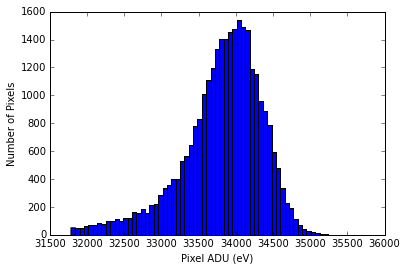

In [57]:
#600ms Exposure
F600data0 = fits.getdata("FLAT600ms.FIT")
F600data = F600data0[150:300, 200:400]
minim = np.mean(F600data)-(np.std(F600data))*3
maxim = np.mean(F600data)+(np.std(F600data))*3
hist(F600data.flatten()+offset[0]-offmean, bins=binless[0], range=[minim, maxim])
print "600ms Exposure"
print "Min:", minim, "Max:", maxim
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()

700ms Exposure
Min: 31168.1976318 Max: 40321.8883057


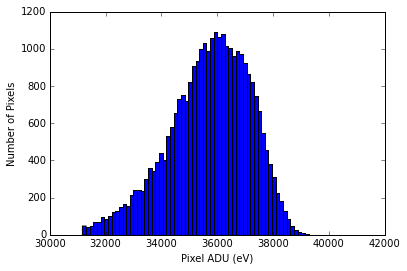

In [58]:
#700ms Exposure
F700data0 = fits.getdata("FLAT700ms.FIT")
F700data = F700data0[150:300, 200:400]
minim = np.mean(F700data)-(np.std(F700data))*3
maxim = np.mean(F700data)+(np.std(F700data))*3
hist(F700data.flatten()+offset[0]-offmean, bins=binless[0], range=[minim, maxim])
print "700ms Exposure"
print "Min:", minim, "Max:", maxim
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()

800ms Exposure
Min: 31123.8231201 Max: 40494.7940674


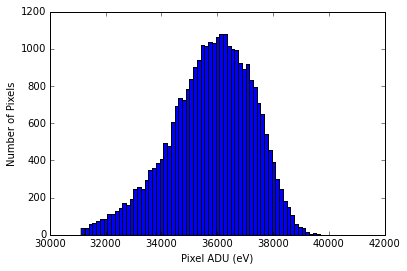

In [59]:
#800ms Exposure
F800data0 = fits.getdata("FLAT800ms.FIT")
F800data = F800data0[150:300, 200:400]
minim = np.mean(F800data)-(np.std(F800data))*3
maxim = np.mean(F800data)+(np.std(F800data))*3
hist(F800data.flatten()+offset[0]-offmean, bins=binless[0], range=[minim, maxim])
print "800ms Exposure"
print "Min:", minim, "Max:", maxim
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()

900ms Exposure
Min: 31111.8712158 Max: 40529.9881592


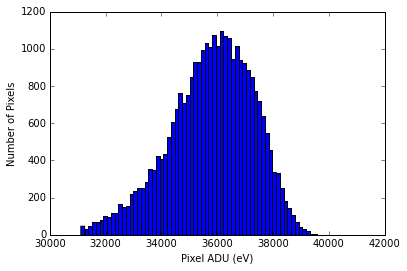

In [60]:
#900ms Exposure
F900data0 = fits.getdata("FLAT900ms.FIT")
F900data = F900data0[150:300, 200:400]
minim = np.mean(F900data)-(np.std(F900data))*3
maxim = np.mean(F900data)+(np.std(F900data))*3
hist(F900data.flatten()+offset[0]-offmean, bins=binless[0], range=[minim, maxim])
print "900ms Exposure"
print "Min:", minim, "Max:", maxim
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()

1000ms Exposure
Min: 31005.2520752 Max: 40270.5447998


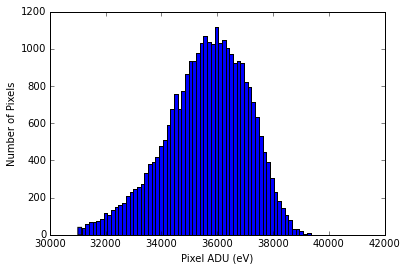

In [61]:
#1000ms Exposure
F1000data0 = fits.getdata("FLAT1000ms.FIT")
F1000data = F1000data0[150:300, 200:400]
minim = np.mean(F1000data)-(np.std(F1000data))*3
maxim = np.mean(F1000data)+(np.std(F1000data))*3
hist(F1000data.flatten()+offset[0]-offmean, bins=binless[0], range=[minim, maxim])
print "1000ms Exposure"
print "Min:", minim, "Max:", maxim
plt.xlabel('Pixel ADU (eV)')
plt.ylabel('Number of Pixels')
plt.show()

With all of our data collected, we compiled the mean counts read by the CCD for each frame into a single array.

In [62]:
# Populate Mean Count Array from Data Input seen above
MCount[0]=np.mean(F100data)
MCount[1]=np.mean(F200data)
MCount[2]=np.mean(F300data)
MCount[3]=np.mean(F400data)
MCount[4]=np.mean(F500data)
MCount[5]=np.mean(F600data)
MCount[6]=np.mean(F700data)
MCount[7]=np.mean(F800data)
MCount[8]=np.mean(F900data)
MCount[9]=np.mean(F1000data)

A Linearity Curve for the Angel Hall Telescope CCD was then produced by plotting Mean Count Number as a function of exposure time. Based on our theory, we expected a range of linear behavior for low exposure times, followed by a deviation in that behavior after a given exposure threshold value.

Linearity Range


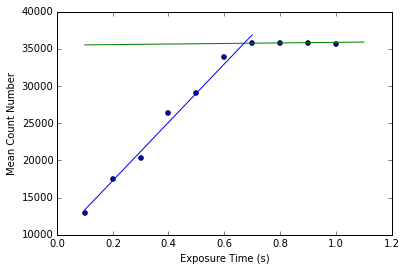

Maximum Exposure Time: 0.65


In [70]:
# Linearity Graph
plt.scatter(exposure, MCount)

# Blue Fit
m, b = np.polyfit(exposure[0:7], MCount[0:7], 1)
yp = polyval([m,b], exposure[0:7])
plt.plot(exposure[0:7], yp)

# Green Fit
mtime = [0.1, exposure[6], exposure[7], exposure[8], exposure[9], 1.1]
m1, b1 = np.polyfit(exposure[6:9], MCount[6:9], 1)
yp1 = polyval([m1,b1], mtime)
plt.plot(mtime, yp1)
print "Linearity Range"
plt.ylabel('Mean Count Number')
plt.xlabel('Exposure Time (s)')

plt.show()
print "Maximum Exposure Time: 0.65"

In the above graph, the CCD's linear behavior is identified with a Blue trendline. An abrupt deviation occurs at around an exposure time of 0.65 seconds. This represents the point at which the CCD is saturated, where the CCD accuracy falls off and further exposure will not greatly change the amount of charge in the pixels. In general, the wider the range of linearity, the better the CCD.

#### IV. Dark Current

Dark Current of the CCD is the last calibration value to measure. Given that our CCD is only being air-cooled by a low-power internal fan, we can expected a measureable amount of Dark Current in our readings. We begin with variable declarations four our ten dark exposure frames. 

In [5]:
# Declarations
Temp   = [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]
DCount = [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]
offset = 10

One Bias Frame was collected in the beginning so that we might compensate for base count level in the CCD, as done in the previous calibration calculations. 

In [6]:
# Bias Compensation
D0data = fits.getdata("DARK0.FIT")
BiasMean=np.mean(D0data)

We began by turning off the internal fan, then collected ten 20-second Dark Frame exposures. The CCD temperature was recorded in the FIT file header, which we stored in the Temp array. 

In [7]:
# Dark Exposure 1

# Read in count array data from DARK1.FIT
D1data0 = fits.getdata("DARK1.FIT")
D1data = D1data0
# Read in CCD Temperature Data from FIT file header and convert from Celsius to Kelvin
Temp[0] = 303.15 + fits.getheader("DARK1.FIT")["TEMPERAT"]

In [8]:
# Dark Exposure 2
D2data0 = fits.getdata("DARK2.FIT")
D2data = D2data0
Temp[1] = 303.15 + fits.getheader("DARK2.FIT")["TEMPERAT"]

In [9]:
# Dark Exposure 3
D3data0 = fits.getdata("DARK3.FIT")
D3data = D3data0
Temp[2] = 303.15 + fits.getheader("DARK3.FIT")["TEMPERAT"]

In [10]:
# Dark Exposure 4
D4data0 = fits.getdata("DARK4.FIT")
D4data = D4data0
Temp[3] = 303.15 + fits.getheader("DARK4.FIT")["TEMPERAT"]

In [11]:
# Dark Exposure 5
D5data0 = fits.getdata("DARK5.FIT")
D5data = D5data0
Temp[4] = 303.15 + fits.getheader("DARK5.FIT")["TEMPERAT"]

In [12]:
# Dark Exposure 6
D6data0 = fits.getdata("DARK6.FIT")
D6data = D6data0
Temp[5] = 303.15 + fits.getheader("DARK6.FIT")["TEMPERAT"]

In [13]:
# Dark Exposure 7
D7data0 = fits.getdata("DARK7.FIT")
D7data = D7data0
Temp[6] = 303.15 + fits.getheader("DARK7.FIT")["TEMPERAT"]

In [14]:
# Dark Exposure 8
D8data0 = fits.getdata("DARK8.FIT")
D8data = D8data0
Temp[7] = 303.15 + fits.getheader("DARK8.FIT")["TEMPERAT"]

In [15]:
# Dark Exposure 9
D9data0 = fits.getdata("DARK9.FIT")
D9data = D9data0
Temp[8] = 303.15 + fits.getheader("DARK9.FIT")["TEMPERAT"]

In [16]:
# Dark Exposure 10
D10data0 = fits.getdata("DARK10.FIT")
D10data = D10data0
Temp[9] = 303.15 + fits.getheader("DARK10.FIT")["TEMPERAT"]

The Mean Count Level read in by the CCD (after compensating for Bias and offset) was stored in the DCount array via the code below.

In [17]:
# Populate Mean Count Array for Dark Captures
DCount[0]=np.mean(D1data) - BiasMean + offset
DCount[1]=np.mean(D2data) - BiasMean + offset
DCount[2]=np.mean(D3data) - BiasMean + offset
DCount[3]=np.mean(D4data) - BiasMean + offset
DCount[4]=np.mean(D5data) - BiasMean + offset
DCount[5]=np.mean(D6data) - BiasMean + offset
DCount[6]=np.mean(D7data) - BiasMean + offset
DCount[7]=np.mean(D8data) - BiasMean + offset
DCount[8]=np.mean(D9data) - BiasMean + offset
DCount[9]=np.mean(D10data) - BiasMean + offset

There are two values in our theoretical evaluation of Dark Current specific to the CCD that we do not currently know; $A$ and $E_g$. By plotting our data against the numbers generated via the model with various values of $A$ and $E_g$, we can generate estimates for these two factors. This step is important as it finishes our Temperature-Dark Current function, which can then be used to generate appropriate Dark Current Bias values to remove from our data at any temperature observed by the Angel Hall CCD. 

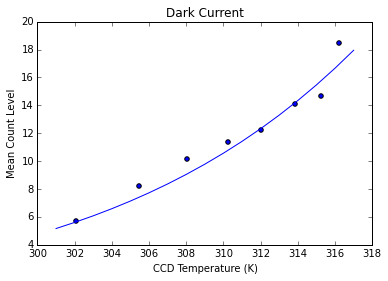

In [20]:
from scipy.optimize import curve_fit

# Variable Declerations
A      = 11000000
Eg     = 01.2
K      = 8.6173324*(10**(-5))
ydata  = [  1,   2,   3,   4,   5,   6,   7,   8,   9,   10,   11,   12,   13,   14,   15,   16,   17]
xdata  = [  301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317 ]
T      = xdata

# Define Dark Current vs. Temp modeling function, described in 'Theory'
def func(i):
    return A*(T[i]**(3/2))* np.exp(-Eg/(2*K*T[i]))

# Calculate theoretical count levels based on Temperature
ydata[0] = func(0)
ydata[1] = func(1)
ydata[2] = func(2)
ydata[3] = func(3)
ydata[4] = func(4)
ydata[5] = func(5)
ydata[6] = func(6)
ydata[7] = func(7)
ydata[8] = func(8)
ydata[9] = func(9)
ydata[10] = func(10)
ydata[11] = func(11)
ydata[12] = func(12)
ydata[13] = func(13)
ydata[14] = func(14)
ydata[15] = func(15)
ydata[16] = func(16)

# Plot curve model
plot(xdata, ydata)
# Plot our collected data
plt.scatter(Temp[1:9], DCount[1:9])
# Label Graph
plt.title("Dark Current")
plt.xlabel('CCD Temperature (K)')
plt.ylabel('Mean Count Level')
# Show Graph
plt.show()

Based on the correlation between our model and collected data, we estimated values of $A$ and $E_g$ as 1.1e07 ADU/pixel/s and 1.20 eV respectively. The Band Gap of Silicon ($E_g$) is 1.11 eV, reasonably close to our estimated Band Gap for the Angel Hall CCD. These Dark Current values will have to be subtracted from any measurements we take on the CCD, in order to compensate for the additional counts generated by the electrons undergoing thermal excitation.

### Summary

In the laboratory experiments conducted here, our goal was to calculate calibration constants for the Angel Hall Observatory Telescope’s Charge-coupled device. The values for Gain, Read-Noise, Linearity, and Dark Current are an important measure of a CCD’s quality, and a significant part of any calculations conducted with CCD measurements. We began by calculating the Gain via comparison of two Flat and two Bias frame samples collected with the CCD. Via the Gain equation described by theory, it was identified as 2.438. The same four arrays of charge were then used to find Read-noise, defined as the standard deviation from the mean value at any given pixel location. The read-noise calibration factor for our CCD was noted as 15.516. These results were similar to those found by other research efforts conducted concurrently on the same CCD. 

For our determination of Linearity, we took ten Flat images with exposure time increasing from 0.1s to 1s. These images were evaluated for mean charge count per pixel, and graphed to view the Gaussian spread of data collected by the CCD. The mean count number was then plotted as a function of exposure time, and we observed a linear trend in the data until an exposure of around 0.65 seconds. This represents the saturation point, where accuracy of the CCD falls off and further exposure will not greatly change the amount of charge in the pixels. Last was our calculation of Dark Current, which came from 10 Dark Frames and a Dark Bias we collected as the CCD heated up due to the current flow of usage. The mean count level for each frame was plotted against the temperature of the CCD after removing the bias factor, and these results were compared to theoretical relation between temperature and Dark Current. As a result, we were able to estimate the unknown constants $A$ and $E_g$ as 1.1e07 ADU/pixel/s and 1.20 eV respectively. Given that the CCD is likely made of silicon and silicon has an $E_g$ of 1.11 eV, these results seem reasonably accurate. 




### Conclusion
Based on the results of our experiments, we can conclude that the CCD in the Angel Hall Telescope is of middling quality. We determine that it has a Gain of 2.438, a Read-Noise of 15.516, a Linearity range of 0.65 seconds, and a Dark Current-Temperature relationship with coefficients $A =$ 1.1e07 ADU/pixel/s and $E_g =$ 1.20 eV. These calibration values will be important when we use the CCD for the collection of science images, as they must be factored into our calculations to ensure the accuracy of our data. Furthermore, determining these coefficients gave us experience working with the Angel Hall Telescope and the CCD for real sampling work. Whenever working with a new telescope or instrumentation setup, calibration values must be calculated first (sometimes they may even change on a nightly basis) before any conclusions or calculations can be conducted on the CCD-collected data.